# Audio declipping with social sparsity 
### Author: Pawel Budzynski

In this exercise I am going to implement audio declipping with social sparsity described in the paper: _Siedenburg, K., Kowalski, M., & Dörfler, M. (2014, May). Audio declipping with social sparsity._

In [1]:
from typing import Callable, Tuple

import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile
import scipy.signal

Load and play sound that is going to be used in the rest of the exercise.

In [ ]:
sample_rate, sound = scipy.io.wavfile.read("music.wav")
IPython.display.Audio(data=sound, rate=sample_rate)

Define signal pre processing function so it matches requirements of the algorithm. 

In [3]:
def normalize_signal(
    signal: np.ndarray,
) -> np.ndarray:
    """Normalize signal values to [-1, 1] range."""
    return signal.astype(np.float64) / 2**15

def clip_signal(
    signal: np.ndarray,
    level: float,
) -> np.ndarray:
    """Takes normalized signal, clip it into a given level and 
    scales it back to [-1, 1] range. 
    """
    return np.clip(signal, -level, level)

In [ ]:
sound_norm = normalize_signal(sound)
plt.plot(sound_norm)
plt.title("Normalized signal.")
plt.show()

sound_clip = clip_signal(sound_norm, 0.5)
plt.plot(sound_clip)
plt.title("Clipped signal.")
plt.show()

IPython.display.Audio(
    data=(sound_clip*2**15).astype(np.int16),
    rate=sample_rate,
)

In [5]:
def get_mask(
    signal: np.ndarray,
    eps: float = 1e-6,
) -> np.ndarray:
    """Get mask marking clipped samples with given accuracy.
    Equality comparison of floating point numbers is not recommended."""
    m1 = signal >= np.max(signal) - eps
    m2 = signal <= np.min(signal) + eps
    return (m1 + m2).astype(np.int16)

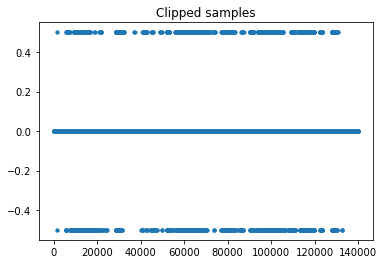

In [6]:
m = get_mask(sound_clip)
plt.scatter(np.arange(0, len(m)), m*sound_clip, marker='.')
plt.title("Clipped samples")
plt.show()

Thresholding rules that might be used in the algorithm. 

In [7]:
def soft_threshold(
    arr: np.ndarray,
    t: float,
) -> np.ndarray:
    """Perform soft thresholding on an array of values."""
    return arr * np.maximum(0, 1 - t / np.abs(arr))

def wgl(
    arr: np.ndarray,
    t: float,
    w: int = 3,
) -> np.ndarray:
    """Windowed Group-Lasso thresholding."""
    kernel = np.ones((1, w))
    neighborhood = scipy.signal.convolve2d(
        np.abs(arr)**2,
        kernel,
        mode='same',
        fillvalue=0.0,
    )
    
    return arr * np.maximum(0, 1 - t / np.sqrt(neighborhood))


def empirical_weiner(
    arr: np.ndarray,
    t: float,
) -> np.ndarray:
    """Perform thresholding using Empirical Weiner rule."""
    return arr * np.maximum(0, 1 - (t**2 / np.abs(arr)**2))


def pew(
    arr: np.ndarray,
    t: float,
    w: int = 3,
) -> np.ndarray:
    """Persistent Empirical Weiner thresholding."""
    kernel = np.ones((1, w))
    neighborhood = scipy.signal.convolve2d(
        np.abs(arr)**2, 
        kernel, 
        mode='same',
        fillvalue=0.0,
    )
    
    return arr * np.maximum(0, 1 - (t**2 / neighborhood))

The unconstrained convex optimization problem 
\begin{equation}
\underset{\alpha}{\mathrm{argmin}} \frac{1}{2} ||y^r - M^r \Phi \alpha ||^2_2 + \frac{1}{2}\left[\theta^{clip} - M^{c}\Phi\alpha\right]^2_{+} + \lambda||\alpha||_1
\end{equation}

Initialization: 
$\alpha^{(0)}\in\mathbb{C}^N, z^{(0)} = \alpha^{(0)}, k = 1, \delta = ||\Phi \Phi^{*}||.$
Do until convergence :

$g1 = -\Phi^{*} {M^{r}}^{T} \left(y^r - M^r \Phi z^{(k-1)}\right)$

$g2 = -\Phi^{*} {M^{c}}^{T} \left[\theta^{clip} - M^c \Phi z^{(k-1)}\right]_{+}$

$\alpha^{(k)} = \mathcal{S}_{\lambda / \delta} 
\left( z^{(k-1)} - \frac{1}{\delta}(g1 + g2) \right)$

$z^{(k)} = \alpha^{(k)} + \gamma \left(\alpha^{(k)} - \alpha^{(k-1)}\right)$

<!-- - $ α^{(t+1)} = \mathcal{S}_{\lambda/L} \left( z^{(t)} + \frac{1}{L}\Phi^* A^* \left( y - A\Phi z^{(t)} \right) \right)$
- $z^{(t+1)} = \alpha^{(t+1)} + \frac{t}{t+5} \left( \alpha^{(t+1)} - \alpha^{(t)} \right)$ -->


Where
- $y$ - observed signal.
- $y^{r}$ - reliable samples of the observed signal $y$.
- $\Phi$ - a dictionary / frame.
- $M^{r}$ - a mask selecting reliable samples from signal.
- $M^{c}$ - a mask matrix selecting clipped samples.
- $\theta^{clip}$ - vector of clipped samples.
- $\mathcal{S}_{\tau}$ - threshold function with threshold $\tau$.

Remembering that $z$ are coefficients, the mentioned elements of the equation can be interpreted in a following way
- $\Phi^{*} s$ - STFT transform (computing coefficients for a signal $s$). 
- $\Phi \alpha$ - inverse STFT transform (reconstructing signal from coefficients $\alpha$).

The goal is to compute coefficients $\hat{\alpha}$ that will allow to reconstruct declipped version of the observed signal $\hat{y} = \Phi^{*}\hat{\alpha}$.

Parameters initialization in practice: 
- $\Phi$ is a Parseval Frame, hence $\Phi\Phi^*x = x$, then $\delta = || \Phi\Phi^*|| = 1$ 
- $\alpha^{(0)} = \Phi y$ 

Implementation note: In the paper masking is done by matrix multiplication in such a way that selected samples perserve their values while others take value of $0$. In this exercise implementation is realised with element wise multiplications. Hence multiplication by transposed matrices in $g1$ and $g2$ were skipped in the implementation as they serve only to get back signal to a correct shape which does not change in case of element wise multiplications.

In [8]:
Phi = lambda a: scipy.signal.istft(a, sample_rate)[-1]
PhiS = lambda s: scipy.signal.stft(s, sample_rate, nperseg=1000)[-1]

In [9]:
def h(theta, x):
    """Implementation of [.]+ operator."""
    zero_idx = (x > theta) + (x < -theta)
    res = theta - x
    res[zero_idx] = 0
    return res

def h_sq(theta, x):
    """Squared hinge function implementation."""
    def h2(z):
        return np.minimum(z, 0)**2
    pos_idx = theta > 0
    neg_idx = theta < 0
    return (
        np.sum(h2(x[pos_idx] - theta[pos_idx]))
        + np.sum(h2(theta[neg_idx] - x[neg_idx]))
    )

def loss_fn(yr, Phi, Mr, Mc, theta, alpha, lambd):
    """Loss function implementation."""
    fr = Phi(alpha)
    return (
        0.5 * np.sum((yr - Mr * fr)**2)
        + 0.5 * h_sq(theta, Mc * fr)
        + lambd * np.sum(np.abs(alpha))
    )

In [10]:
# initialize algorithm
sound_clip = clip_signal(sound_norm, 0.6)

# Transform and inverse transform signal to get proper shape array.
y = Phi(PhiS(sound_clip))
# Matrix selecting clipped samples.
Mc = get_mask(y)
# Matrix selecting reliable samples from the signal.
Mr = 1 - Mc
# Reliable samples of the observed signal.
yr = Mr * y
# The vector of clipped samples.
theta_c = y * Mc

# Initialize algorithm parameters.
a = PhiS(y)
z = a.copy()

# During the algorithm lambda value will be decreased each time a convegence
# is reached. Values from lambda vector are taken from the paper.
lambdas = (0.1, 0.0464, 0.0215, 0.01, 0.0046, 0.0022, 0.001, 0.0005)
delta = 1
# Gamma value proposed in the paper as the one with the best performance.
gamma = 0.9
max_iter = 1000 # maximal number of iterations accepted
eps = 1e-3 # minimal loss change before convergence
loss = []
i = 0

for _ in range(max_iter):
    lambd = lambdas[i]
    a_prev = a.copy()
    sound_rec = Phi(z) 
    
    g1 = -PhiS(yr - Mr * sound_rec)
    g2 = -PhiS(h(theta_c, Mc * sound_rec))
    
    a = soft_threshold(z - (1/delta) * (g1 + g2), lambd/delta)
    z = a + gamma*(a - a_prev)
    
    loss.append(loss_fn(yr, Phi, Mr, Mc, theta_c, z, lambd))
    if len(loss) > 2 and abs(loss[-2] - loss[-1]) < eps:
        i += 1
        if i < len(lambdas):
            continue
        else:
            break

In [ ]:
# Inverse STFT to reconstruct signal from coefficients.
sound_rec = Phi(a)

plt.plot(y)
plt.title("Clipped signal.")
plt.show()

plt.plot(sound_rec)
plt.title("Declipped signal.")
plt.show()

plt.plot(loss)
plt.title("Loss function.")
plt.show()

IPython.display.Audio(
    data=(sound_rec*2**15).astype(np.int16),
    rate=sample_rate,
)

In the experiment above the relaxed version or declipping algorithm was implemented successfully and produced great results for $\theta^{clip} = 0.6$. The peaks of reconstructed signal almost reach their original points and the output sound has significantly better quality. In the later part of the exercise more experiments with algorith parameters are discussed.

In [12]:
def audio_declipping(
    audio: np.ndarray,
    sample_rate: int,
    gamma: float = 0.9,
    threshold_fn: Callable = soft_threshold,
    max_iter: int = 1000,
    eps: float = 1e-3,
) -> Tuple[np.ndarray]:
    """Audio declipping with social sparsity. Performs audio declipping 
    for given signal. Returns reconstructed signal and values of loss function.
    
    Parameters:
        audio: clipped audio signal. 
        sample_rate: audio sample rate.
        gamma: gamma parameter used in the algorithm.
        threshold_fn: thresholding rule to use.
        max_iter: maximum number of iterations allowed.
        eps: maximal difference in loss before convergence.
    """
    
    # STFT and Inverse STFT helper functions.
    Phi = lambda a: scipy.signal.istft(a, sample_rate)[-1]
    PhiS = lambda s: scipy.signal.stft(s, sample_rate, window='hann', nperseg=512)[-1]
    
    # Values vectors and masks used in the algorithm. 
    y = Phi(PhiS(audio))
    Mc = get_mask(y)
    Mr = 1 - Mc
    yr = Mr * y
    theta_c = y * Mc

    # Parameters initialization.
    a = PhiS(y)
    z = a.copy()

    # Value of lambda parameter are going to decrease each time convergence
    # was reached. Values for lambda are taken from the original paper. 
    lambdas = (0.1, 0.0464, 0.0215, 0.01, 0.0046, 0.0022, 0.001, 0.0005)
    delta = 1
    loss = []
    i = 0

    for _ in range(max_iter):
        lambd = lambdas[i]
        a_prev = a.copy()
        sound_rec = Phi(z) 

        g1 = -PhiS(yr - Mr * sound_rec)
        g2 = -PhiS(h(theta_c, Mc * sound_rec))

        a = threshold_fn(z - (1/delta) * (g1 + g2), lambd/delta)
        z = a + gamma*(a - a_prev)

        loss.append(loss_fn(yr, Phi, Mr, Mc, theta_c, z, lambd))
        if len(loss) > 2 and abs(loss[-2] - loss[-1]) < eps:
            i += 1
            if i < len(lambdas):
                continue
            else:
                break
            
    return Phi(z)[:len(audio)], loss

In [ ]:
sound_clip = clip_signal(sound_norm, 0.6)
audio_rec, loss = audio_declipping(
    sound_clip, 
    sample_rate,
)

plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(sound_norm)
plt.title("Original signal.")
plt.subplot(3, 1, 2)
plt.plot(audio_rec)
plt.title("Declipped signal")
plt.subplot(3, 1, 3)
plt.plot(loss)
plt.title("Loss function.")
plt.show()

IPython.display.Audio(
    data=(audio_rec*2**15).astype(np.int16),
    rate=sample_rate,
)

In [14]:
def snr(clipped_signal, declipped_signal):
    """Return signal to noise ratio given 
    clipped signal and its declipped version.
    """
    mc = get_mask(clipped_signal)
    return 20 * np.log(
        np.linalg.norm(mc*clipped_signal) 
        / np.linalg.norm(mc*(clipped_signal-declipped_signal))
    )

In [15]:
snr(sound_clip, audio_rec)

39.45132557883333

## Parameters discussion
### Clip level vs SNR
In this part experiment is performed to check how clip level impacts SNR for declipped audio.

clip level: 0.8, SNR: 51.3, loss: 2.33, n_iter: 181
clip level: 0.6, SNR: 39.45, loss: 2.86, n_iter: 193
clip level: 0.4, SNR: 31.97, loss: 14.46, n_iter: 318
clip level: 0.2, SNR: 21.01, loss: 99.18, n_iter: 414


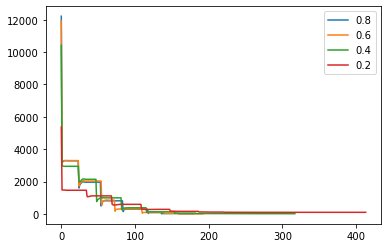

In [16]:
theta_levels = (0.8, 0.6, 0.4, 0.2)
for th_clip in theta_levels:
    sound_clip = clip_signal(sound_norm, th_clip)
    audio_rec, loss = audio_declipping(
        sound_clip, 
        sample_rate,
    )
    snr_ = round(snr(sound_clip, audio_rec), 2)
    loss_ = round(loss[-1], 2)
    print(f"clip level: {th_clip}, SNR: {snr_}, loss: {loss_}, n_iter: {len(loss)}")
    
    plt.plot(loss)
plt.legend(theta_levels)
plt.show()

### $\gamma$ value selection impact

Gamma: -1, SNR: 39.64, loss: 3.01, n_iter: 436
Gamma: -0.75, SNR: 39.66, loss: 3.01, n_iter: 1000
Gamma: -0.5, SNR: 39.6, loss: 2.97, n_iter: 949
Gamma: 0, SNR: 39.57, loss: 2.95, n_iter: 756
Gamma: 0.5, SNR: 39.53, loss: 2.91, n_iter: 496
Gamma: 0.75, SNR: 39.51, loss: 2.89, n_iter: 334
Gamma: 0.9, SNR: 39.45, loss: 2.86, n_iter: 193


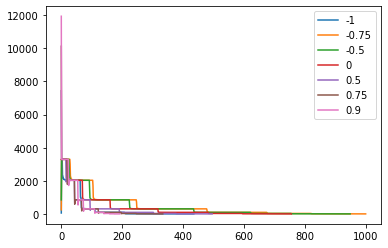

In [17]:
sound_clip = clip_signal(sound_norm, 0.6)
gamma_values = (-1, -0.75, -0.5, 0, 0.5, 0.75, 0.9)
for gamma in gamma_values:
    audio_rec, loss = audio_declipping(
        sound_clip, 
        sample_rate,
        gamma=gamma,
    )
    snr_ = round(snr(sound_clip, audio_rec), 2)
    loss_ = round(loss[-1], 2)
    print(f"Gamma: {gamma}, SNR: {snr_}, loss: {loss_}, n_iter: {len(loss)}")
    
    plt.plot(loss)
    
plt.legend(gamma_values)
plt.show()

### Thresholding rules

Threshold rule: soft_threshold, SNR: 39.45, loss: 2.86, n_iter: 193
Threshold rule: wgl, SNR: 38.62, loss: 1.36, n_iter: 177
Threshold rule: empirical_weiner, SNR: 31.53, loss: 0.8, n_iter: 287
Threshold rule: pew, SNR: 31.48, loss: 0.45, n_iter: 224


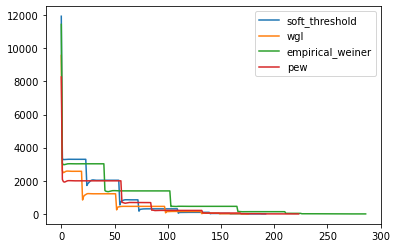

In [18]:
sound_clip = clip_signal(sound_norm, 0.6)
threshold_functions = (soft_threshold,  wgl, empirical_weiner, pew)
for threshold_fn in threshold_functions:
    audio_rec, loss = audio_declipping(
        sound_clip, 
        sample_rate,
        threshold_fn=threshold_fn,
    )
    snr_ = round(snr(sound_clip, audio_rec), 2)
    loss_ = round(loss[-1], 2)
    print(f"Threshold rule: {threshold_fn.__name__}, SNR: {snr_}, "
          f"loss: {loss_}, n_iter: {len(loss)}")
    
    plt.plot(loss)
    
plt.legend([fn.__name__ for fn in threshold_functions])
plt.show()

## Conclusions
- The algorithm implemented allows for audio declipping without prior knowledge of the original signal. 
- The quality of the output of the algorithm decreases together with decreasing level of $\theta^{clip}$. The more of original signal was lost the harder it gets to reconsrtuct its original form. For lower clipping values execution of the algorithm takes longer.
- The $\gamma$ parameter seems not to have impact on the quality of the results however it impacts performance of the algorithm. The experiments confirm observation given in the paper that the value of $0.9$ leads to the fastest convergence.
- Empirical Weiner thresholding rule seems to produce better results as the loss reaches lower levels however it takes longer to converge.
- Values of $\lambda$ parameter are crucial for the output of the algorithm however in the exercise their selection was limited to the set of values used in the paper.